Doc title: **Amazon Returns Report Analyzation - Specific Duration**

Article notes: The products analyzation of the Amazon FBA return cases that exported from 'Reports/Fulfillment/All Orders','Reports/Return Reports/Seller Fulfilled Return Reports' and 'Reports/Fulfillment/FBA Customer Returns' @Amazon Seller Central.

文章备注：FBA退货产品款式占比分析（按月）

Last modified date: 2019-09-15 03:13:18 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['Microsoft Yahei']  # Fix Chinese unrecognized issue 
plt.rcParams['axes.unicode_minus']=False # Fix Minus Sign unrecognized issue

# 特定时段全部订单数据

In [2]:
# 数据来自Amazon后台: “Reports/Fulfillment/All Orders”导出txt文件，转xlsx文件。（“product-name/asin”列已删除）
order_df = pd.read_excel('data/amz_all_orders_201908.xlsx', usecols=['sku', 'quantity'])
# 添加款式字段
order_df['model'] = pd.Series(order_df['sku'].str.replace('CA-', '')).str.slice(0,6)
order_df.head()

,sku,quantity,model
0,CA-HM0731-2240,0,HM0731
1,CA-HM0722-139,1,HM0722
2,HM0720-140,1,HM0720
3,CA-HM0701-140,1,HM0701
4,CA-HM0722-2539,0,HM0722


# 该时段FBM退货数据

In [3]:
# 数据来自Amazon后台: “Reports/Return Reports/Seller Fulfilled Return Reports”导出tsv文件，转csv文件。（“asin/item-name”列已删除）
fbm_df = pd.read_csv('data/amz_reutrns_fbm_201908.csv', usecols=['Merchant SKU', 'Return quantity', 'Return reason'])
# 添加款式字段
fbm_df['model'] = pd.Series(fbm_df['Merchant SKU'].str.replace('CA-', '')).str.slice(0,6)
fbm_df.head()

,Merchant SKU,Return quantity,Return reason,model
0,HM0738-C-39,1,AMZ-PG-MISORDERED,HM0738
1,HM0701-H-40,1,AMZ-PG-APP-TOO-SMALL,HM0701
2,HM0701-B-39,1,AMZ-PG-APP-STYLE,HM0701
3,HM0742-0238,1,CR-UNWANTED_ITEM,HM0742
4,HM0719-1035,1,CR-MISSED_ESTIMATED_DELIVERY,HM0719


# 该时段FBA退货数据

In [4]:
# 数据来自Amazon后台: “Reports/Fulfillment/FBA Customer Returns”导出csv文件。（“asin/fnsku/product-name”列已删除）
fba_df = pd.read_csv('data/amz_reutrns_fba_201908.csv', usecols=['sku', 'quantity', 'reason', 'customer-comments'])
# 添加款式字段
fba_df['model'] = pd.Series(fba_df['sku'].str.replace('CA-', '')).str.slice(0,6)
fba_df.head()

,sku,quantity,reason,customer-comments,model
0,HM0722-B-39,1,APPAREL_STYLE,NaN,HM0722
1,HM0803-3246,1,APPAREL_TOO_SMALL,size runs very small.,HM0803
2,HM0731-Z-39,1,APPAREL_STYLE,"heavier than expected, not comfortable",HM0731
3,HM0737-Z-40,1,APPAREL_STYLE,I don't like the quality. The soles are extre...,HM0737
4,HM0722-H-40,1,QUALITY_UNACCEPTABLE,Fit / style issue,HM0722


In [5]:
# 以下语句将所有不重复的FBA顾客退货留言输出保存到CSV文件。
# fba_df['customer-comments'].dropna().drop_duplicates().to_csv('output/amz_returns_customer_comments_201907.csv', header=['customer-comments'])

# 退货款式情况统计

In [6]:
returns_df = fba_df.groupby('model').sum().merge(fbm_df.groupby('model').sum(), how='outer', left_on='model', right_on='model', sort=True).fillna(0)
returns_df['count'] = returns_df['quantity'] + returns_df['Return quantity']

# 全部订单销量款式情况统计

In [7]:
sales_df = (order_df.groupby('model').sum())
sales_df = sales_df[sales_df.quantity > 0]

# 二表合一

In [8]:
result_df = sales_df.merge(returns_df, how='left', left_on='model', right_on='model', sort=True).fillna(0)
result_df.reset_index(inplace=True)
result_df.columns = ['款式', '销售数量', 'FBA退货数量', 'FBM退货数量', '退货总数']
result_df['退货比例'] = round(result_df['退货总数'] / result_df['销售数量'] * 100, 2)
result_df

,款式,销售数量,FBA退货数量,FBM退货数量,退货总数,退货比例
0,HM0505,27,1.0,0.0,1.0,3.70
1,HM0701,736,51.0,6.0,57.0,7.74
2,HM0702,1,0.0,0.0,0.0,0.00
3,HM0706,26,1.0,0.0,1.0,3.85
4,HM0707,7,0.0,0.0,0.0,0.00
5,HM0708,1,0.0,0.0,0.0,0.00
6,HM0709,13,5.0,0.0,5.0,38.46
7,HM0711,3,1.0,0.0,1.0,33.33
8,HM0713,8,1.0,0.0,1.0,12.50
9,HM0714,5,0.0,0.0,0.0,0.00


# 商品款式退货率排序图表

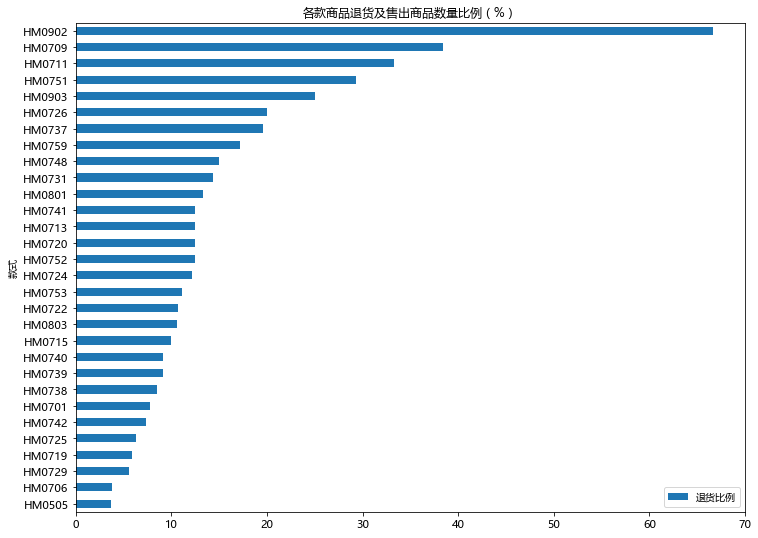

In [9]:
bar_df = result_df[result_df.退货比例>0].sort_values(by='退货比例', ascending=True)
bar_df.plot(
    kind = 'barh', 
    x = 0,
    y = '退货比例',
    grid = False,
    table = False,
    title = '各款商品退货及售出商品数量比例（%）', 
    figsize = (12, 9),
    fontsize = 11
)

# 特定款式退货原因比例图表

In [10]:
SELECTED_MODEL = 'HM0701'

In [11]:
model_fba_df = fba_df[fba_df.model == SELECTED_MODEL][['model', 'sku', 'quantity', 'reason', 'customer-comments']]
model_fbm_df = fbm_df[fbm_df.model == SELECTED_MODEL][['model', 'Merchant SKU', 'Return quantity', 'Return reason']]
model_fbm_df.columns = ['model', 'sku', 'quantity', 'reason']

model_df = model_fba_df.merge(model_fbm_df, how='outer', on=['model', 'sku', 'quantity', 'reason'])

model_df.head(20)

,model,sku,quantity,reason,customer-comments
0,HM0701,HM0701-X-39,1,APPAREL_TOO_SMALL,NaN
1,HM0701,HM0701-X-39,1,APPAREL_TOO_SMALL,NaN
2,HM0701,HM0701-H-39,1,SWITCHEROO,NaN
3,HM0701,HM0701-X-35,1,APPAREL_TOO_SMALL,NaN
4,HM0701,HM0701-X-35,1,APPAREL_TOO_SMALL,NaN
5,HM0701,HM0701-X-40,1,UNDELIVERABLE_INSUFFICIENT_ADDRESS,NaN
6,HM0701,HM0701-B-40,1,MISORDERED,Too small.
7,HM0701,HM0701-X-40,1,APPAREL_STYLE,color not as descibed
8,HM0701,HM0701-R-42,1,APPAREL_STYLE,NaN
9,HM0701,HM0701-B-36,1,NEVER_ARRIVED,Undeliverable / returning to seller


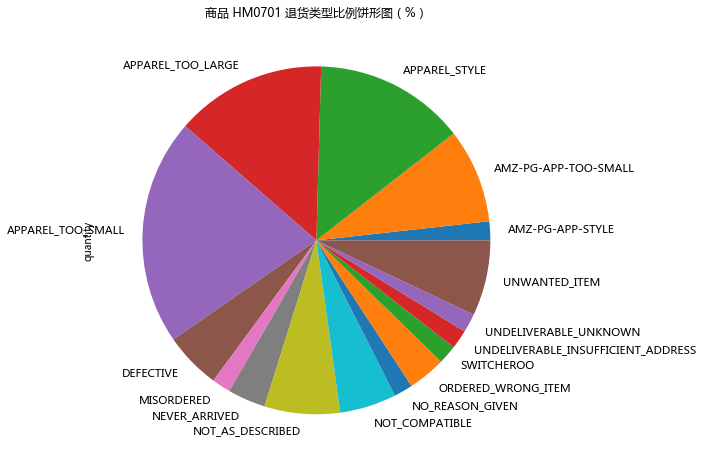

In [12]:
pie_df = model_df.groupby('reason').sum()
pie_df.plot(
    kind='pie', 
    y = 'quantity',
    grid = False,
    table = False,
    title = '商品 {} 退货类型比例饼形图（%）'.format(SELECTED_MODEL), 
    legend = False, 
    figsize = (8, 8),
    fontsize = 11
)

[返回目录](amz_returns_catalog.ipynb)